In [55]:
import numpy as np
import scipy as sp
import mcfit
from vega import VegaInterface, FitResults
import matplotlib.pyplot as plt
from astropy.io import fits

In [57]:
vega = VegaInterface('../tests/main-test_p3d.ini')

INFO: reading input Pk /global/u1/a/acuceu/envs/picca/vega/vega/models/PlanckDR12/PlanckDR12.fits
Reading data file /global/cfs/projectdirs/desi/users/acuceu/notebooks_perl/vega/p3d/roger_code/data.txt

Reading distortion matrix file /global/homes/a/acuceu/scratch/picca_on_mocks/y5/v9.0.0/desi-4.124-4-prod/baseline/correlations/dmat_lya_lya_0_10.fits.gz

Reading covariance matrix file /global/cfs/projectdirs/desi/users/acuceu/notebooks_perl/vega/p3d/roger_code/covariance.txt



/global/homes/a/acuceu/.conda/envs/picca/lib/python3.10/site-packages/mcfit/mcfit.py:176: UserWarning: input must be log-spaced
  warnings.warn("input must be log-spaced")


### Compute and plot model vs data

In [58]:
model = vega.compute_model(run_init=False)['lyaxlya']

In [59]:
num_ells = vega.corr_items['lyaxlya'].data_coordinates.num_ells
num_bins = vega.corr_items['lyaxlya'].data_coordinates.num_bins

model_ells = model.reshape(num_ells, num_bins)
data_ells = vega.data['lyaxlya'].data_vec.reshape(num_ells, num_bins)
sigma_ells = np.sqrt(vega.data['lyaxlya'].cov_mat.diagonal()).reshape(num_ells, num_bins)

Text(0, 0.5, '$k P_\\mathcal{l}(k)$ [$h^2$/$\\mathrm{Mpc}^2$]')

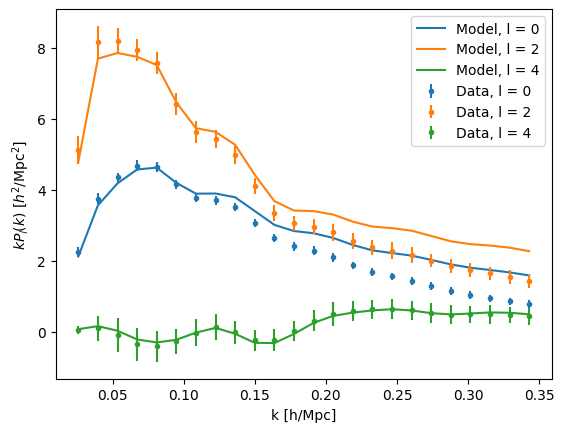

In [60]:
k = vega.corr_items['lyaxlya'].data_coordinates.k_centers
colors = ['C0', 'C1', 'C2']
for xi, data, sig, c in zip(model_ells, data_ells, sigma_ells, colors):
    plt.plot(k, xi*k, c=c, label=f'Model, l = {int(c[1])*2}')
    plt.errorbar(k, data*k, yerr=sig*k, color=c, fmt='.', label=f'Data, l = {int(c[1])*2}')

plt.legend()
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\mathcal{l}(k)$ [$h^2$/$\mathrm{Mpc}^2$]')

### Compute and plot high resolution P(k) model

In [61]:
k_highres = np.linspace(0, 0.35, 1001)
k_highres_edges = np.c_[k_highres[:-1], k_highres[1:]]
k_highres_centers = k_highres_edges.mean(1)

In [62]:
# %%timeit
vega.models['lyaxlya'].P3D.sph_kernels = vega.models['lyaxlya'].P3D.compute_sph_kernels(
    k_highres_edges, k_highres_centers, vega.models['lyaxlya'].P3D.r_window_grid)
model = vega.compute_model(run_init=False)['lyaxlya']

model_ells = model.reshape(num_ells, k_highres_centers.size)

/global/u1/a/acuceu/envs/picca/vega/vega/p3d_model.py:136: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * ((105 / kr - 2 * kr) * np.cos(kr)
/global/u1/a/acuceu/envs/picca/vega/vega/p3d_model.py:137: RuntimeWarning: divide by zero encountered in divide
  + (22 - 105 / kr**2) * np.sin(kr)
/global/u1/a/acuceu/envs/picca/vega/vega/p3d_model.py:137: RuntimeWarning: invalid value encountered in multiply
  + (22 - 105 / kr**2) * np.sin(kr)


Text(0, 0.5, '$k P_\\mathcal{l}(k)$ [$h^2$/$\\mathrm{Mpc}^2$]')

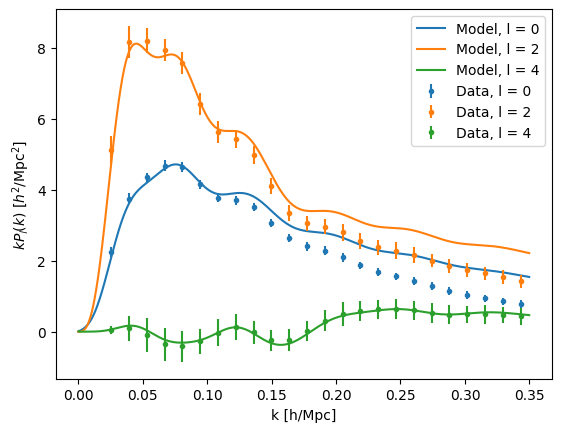

In [63]:
k = vega.corr_items['lyaxlya'].data_coordinates.k_centers
colors = ['C0', 'C1', 'C2']
for xi, data, sig, c in zip(model_ells, data_ells, sigma_ells, colors):
    plt.plot(k_highres_centers, xi*k_highres_centers, c=c, label=f'Model, l = {int(c[1])*2}')
    plt.errorbar(k, data*k, yerr=sig*k, color=c, fmt='.', label=f'Data, l = {int(c[1])*2}')
    
plt.legend()
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\mathcal{l}(k)$ [$h^2$/$\mathrm{Mpc}^2$]')

### Compute and plot best fit P(k) model (from vega output file)

In [68]:
hdul = fits.open('../tests/output/test_v2.fits')

In [69]:
pars = {name: val for name, val in zip(hdul[1].data['names'], hdul[1].data['values'])}

# %%timeit
vega.models['lyaxlya'].P3D.sph_kernels = vega.models['lyaxlya'].P3D.compute_sph_kernels(
    k_highres_edges, k_highres_centers, vega.models['lyaxlya'].P3D.r_window_grid)
model = vega.compute_model(pars, run_init=False)['lyaxlya']

model_ells = model.reshape(num_ells, k_highres_centers.size)

Text(0, 0.5, '$k P_\\mathcal{l}(k)$ [$h^2$/$\\mathrm{Mpc}^2$]')

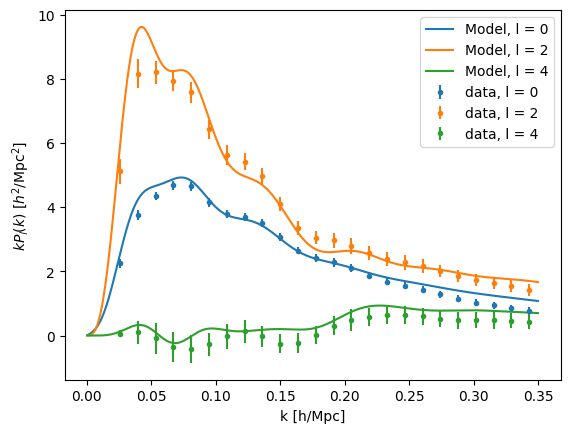

In [70]:
k = vega.corr_items['lyaxlya'].data_coordinates.k_centers
colors = ['C0', 'C1', 'C2']
for xi, data, sig, c in zip(model_ells, data_ells, sigma_ells, colors):
    plt.plot(k_highres_centers, xi*k_highres_centers, c=c, label=f'Model, l = {int(c[1])*2}')
    plt.errorbar(k, data*k, yerr=sig*k, color=c, fmt='.', label=f'data, l = {int(c[1])*2}')
    
plt.legend()
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'$k P_\mathcal{l}(k)$ [$h^2$/$\mathrm{Mpc}^2$]')

In [71]:
vega.compute_model()
vega.chi2(pars)

85.21182570192464